<a href="https://colab.research.google.com/github/saltycookie/RLIntroNotebook/blob/main/K_armed_Bandit_Testbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import abc
import matplotlib.pyplot as plt

In [181]:
def random_argmax(arr, axis=None):
  max_values_along_axis = np.max(arr, axis, keepdims=True)
  is_max_mask = (arr == max_values_along_axis)
  random_tiebreaker = np.where(is_max_mask, np.random.rand(*arr.shape), -1)
  return np.argmax(random_tiebreaker, axis)

def random_argmin(arr, axis=None):
  max_values_along_axis = np.min(arr, axis, keepdims=True)
  is_max_mask = (arr == max_values_along_axis)
  random_tiebreaker = np.where(is_max_mask, np.random.rand(*arr.shape), -1)
  return np.argmax(random_tiebreaker, axis)

def softmax(x, axis=-1):
  e_x = np.exp(x - np.max(x, axis, keepdims=True))
  return e_x / np.sum(e_x, axis, keepdims=True)

def probabilistic_selection(probabilities, axis=None):
  cumulative_probs = np.cumsum(probabilities, axis)
  random_numbers = np.random.rand(*probabilities.shape[:-1], 1)
  selected_indices = np.argmax(cumulative_probs > random_numbers, axis)
  return selected_indices


In [214]:
class KArmedBanditEnv(abc.ABC):
  def __init__(self, k, reward_std):
    self.k = k
    self.reward_std = reward_std
    self.q_star = np.random.normal(4, 1, k)

  def step(self, action):
    reward = np.random.normal(self.q_star[action], self.reward_std)
    return reward


class Agent(abc.ABC):
  @abc.abstractmethod
  def act(self):
    pass

  @abc.abstractmethod
  def update(self, action, reward):
    pass


class ActionValueBasedAgent(Agent):
  def __init__(self, num_runs, k, init_q=0.0, alpha=0.0):
    self.k = k
    self.num_runs = num_runs
    self.q = np.zeros(shape=(num_runs, k)) + init_q
    self.n = np.zeros(shape=(num_runs, k), dtype=int)
    self.alpha = alpha
    self.num_steps = 0

  @abc.abstractmethod
  def act(self):
    pass

  def update(self, action, reward):
    selected_indices = np.arange(action.shape[0]), action
    self.n[selected_indices] += 1
    self.q[selected_indices] += (reward - self.q[selected_indices]) * (
        self.alpha if self.alpha else 1.0 / self.n[selected_indices])
    self.num_steps += 1


class EpsilonGreedyAgent(ActionValueBasedAgent):
  def __init__(self, num_runs, k, init_q=0.0, alpha=0.0, epsilon=0.0):
    super().__init__(num_runs, k, init_q, alpha)
    self.epsilon = epsilon

  def act(self):
    if not self.epsilon:
      return random_argmax(self.q, axis=1)
    is_rand_mask = np.random.rand(self.q.shape[0]) < self.epsilon
    return np.where(is_rand_mask,
                    np.random.randint(0, self.k, size=self.q.shape[0]),
                    random_argmax(self.q, axis=1))


class UCBAgent(ActionValueBasedAgent):
  def __init__(self, num_runs, k, init_q=0.0, alpha=0.0, c=1.0):
    super().__init__(num_runs, k, init_q, alpha)
    self.c = c

  def act(self):
    if self.num_steps == 0:
      return np.random.randint(0, self.k, size=self.q.shape[0])
    has_zero_mask = np.any(self.n == 0, axis=1)
    return np.where(
        has_zero_mask,
        random_argmin(self.n, axis=1),
        random_argmax(
            self.q + self.c * np.sqrt(
                np.log(self.num_steps) / np.clip(self.n, 1, None)), axis=1))


class GradientBanditAgent(Agent):
  def __init__(self, num_runs, k, alpha_h=0.1, alpha_r=0.0):
    self.k = k
    self.num_runs = num_runs
    self.h = np.zeros((num_runs, k))
    self.alpha_h = alpha_h
    self.alpha_r = alpha_r
    self.num_steps = 0
    self.r = np.zeros(num_runs)

  def act(self):
    pi = softmax(self.h)
    return probabilistic_selection(pi, axis=-1)

  def update(self, action, reward):
    self.num_steps += 1
    pi = softmax(self.h, axis=-1)
    delta_taken_actions = (
        self.alpha_h * (reward - self.r)[:, np.newaxis] * (1 - pi))
    delta_other_actions = (
        self.alpha_h * (self.r - reward)[:, np.newaxis] * pi)
    delta_mask = np.zeros_like(self.h)
    delta_mask[np.arange(action.shape[0]), action] = 1
    self.h += np.where(delta_mask, delta_taken_actions, delta_other_actions)
    self.r += (
        self.alpha_r if self.alpha_r else 1.0 / self.num_steps) * (
            reward - self.r)


def simulate(env, agent, num_steps):
  rewards = []
  for _ in range(num_steps):
    action = agent.act()
    reward = env.step(action)
    agent.update(action, reward)
    rewards.append(np.mean(reward))
  return rewards


In [221]:
def simulate_and_plot(env, agent, num_steps, title):
  rewards = simulate(env, agent, num_steps)
  plt.plot(rewards, label=title)

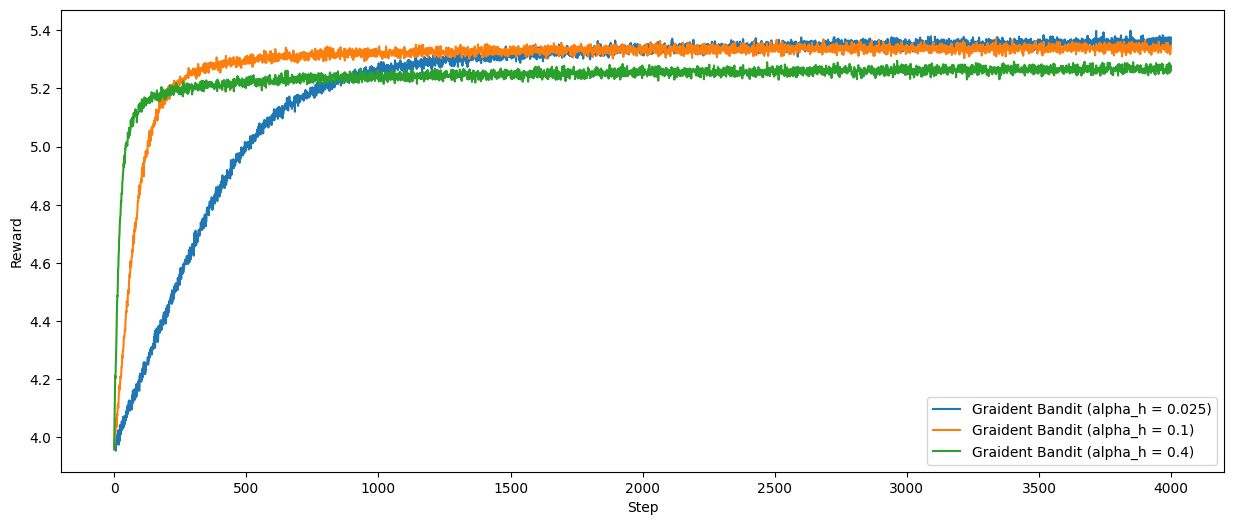

In [222]:
env = KArmedBanditEnv(10, 1)
num_steps = 4000
num_runs = 10000

plt.figure(figsize=(15, 6))

simulate_and_plot(
    env,
    GradientBanditAgent(num_runs, env.k, alpha_h=0.025),
    num_steps,
    'Graident Bandit (alpha_h = 0.025)')

simulate_and_plot(
    env,
    GradientBanditAgent(num_runs, env.k, alpha_h=0.1),
    num_steps,
    'Graident Bandit (alpha_h = 0.1)')

simulate_and_plot(
    env,
    GradientBanditAgent(num_runs, env.k, alpha_h=0.4),
    num_steps,
    'Graident Bandit (alpha_h = 0.4)')

plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()

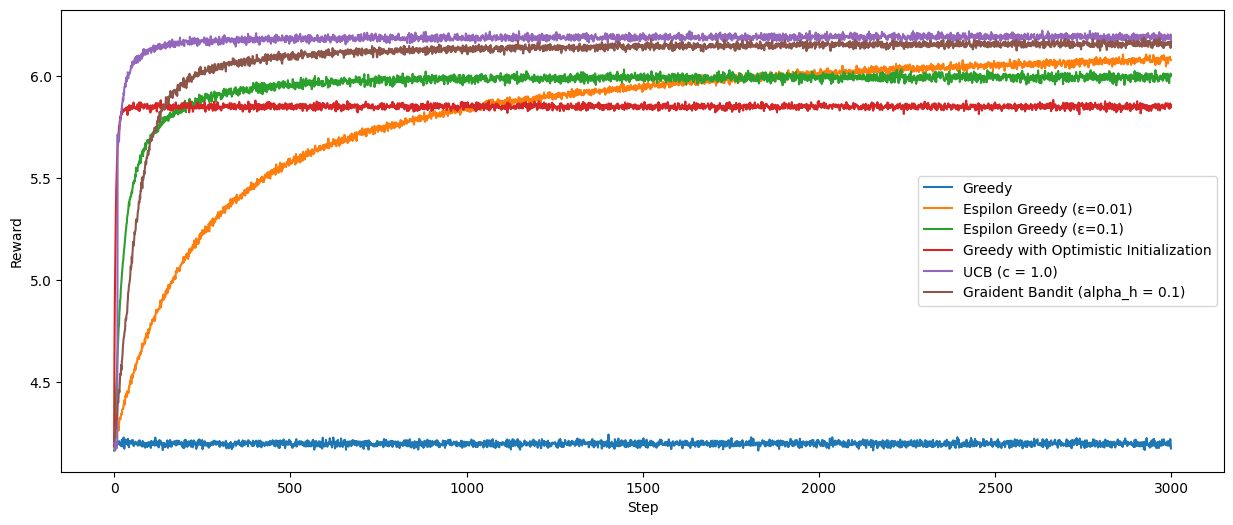

In [223]:
env = KArmedBanditEnv(10, 1)
num_steps = 3000
num_runs = 10000

plt.figure(figsize=(15, 6))

simulate_and_plot(
    env,
    EpsilonGreedyAgent(num_runs, env.k, epsilon=0.0),
    num_steps,
    'Greedy')

simulate_and_plot(
    env,
    EpsilonGreedyAgent(num_runs, env.k, epsilon=0.01),
    num_steps,
    'Espilon Greedy (ε=0.01)')

simulate_and_plot(
    env,
    EpsilonGreedyAgent(num_runs, env.k, epsilon=0.1),
    num_steps,
    'Espilon Greedy (ε=0.1)')

simulate_and_plot(
    env,
    EpsilonGreedyAgent(num_runs, env.k, init_q=5),
    num_steps,
    title='Greedy with Optimistic Initialization')

simulate_and_plot(
    env,
    UCBAgent(num_runs, env.k),
    num_steps,
    title='UCB (c = 1.0)')

simulate_and_plot(
    env,
    GradientBanditAgent(num_runs, env.k),
    num_steps,
    title='Graident Bandit (alpha_h = 0.1)')

plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()